In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
df = pd.read_csv("telecom_users.csv")

In [5]:
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [6]:
df.shape

(5986, 22)

In [7]:
# no duplicates customerID
df[["customerID", "Unnamed: 0"]].nunique()

customerID    5986
Unnamed: 0    5986
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


### PREPROCESSING

In [9]:
# TotalCharges must be float64
# Error: df['TotalCharges'] = df['TotalCharges'].astype('float64')
# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
# to_numeric: ValueError: Unable to parse string " " at position 356

In [10]:
# Check empty values in 'TotalCharges' observations
index_list=[]
for index, row in df[['TotalCharges']].iterrows():
        if (row[0] == " "):
            index_list.append(index)
print(index_list)

[356, 634, 2771, 3086, 3255, 4326, 5375, 5382, 5695, 5951]


In [11]:
# Check if empty values in 'TotalCharges' correspond to tenure=0
idx_list=[]
for index, row in df[['tenure']].iterrows():
        if (row[0] == 0):
            idx_list.append(index)
print(idx_list)

[356, 634, 2771, 3086, 3255, 4326, 5375, 5382, 5695, 5951]


In [12]:
# All empty values in TotalCharges correspond to custmers with tenure equal to 0. 
# Replace empty values with 0
df.TotalCharges.replace(" ", "0", inplace=True)
print(df.TotalCharges[index_list])

356     0
634     0
2771    0
3086    0
3255    0
4326    0
5375    0
5382    0
5695    0
5951    0
Name: TotalCharges, dtype: object


In [13]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [14]:
y = df['Churn']
df = df.drop(['Unnamed: 0', 'customerID', 'Churn'], axis=1)

In [15]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [16]:
# Create a boolean mask for categorical and numerical columns
numeric_vars = df.dtypes[df.dtypes != 'object'].index
cat_vars = df.dtypes[(df.dtypes == 'object')].index

In [17]:
df[cat_vars].describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,3050,5020,3082,4195,5396,2848,2627,2982,2605,2640,2960,2389,2356,3269,3528,2006


In [18]:
df[numeric_vars].describe()

,tenure,MonthlyCharges,TotalCharges
count,5986.000000,5986.000000,5986.000000
mean,32.468760,64.802213,2294.221559
std,24.516391,30.114702,2274.164124
min,0.000000,18.250000,0.000000
25%,9.000000,35.650000,401.587500
50%,29.000000,70.400000,1408.575000
75%,56.000000,89.900000,3841.500000
max,72.000000,118.750000,8684.800000


### EDA

In [19]:
X = df.copy(deep=True)

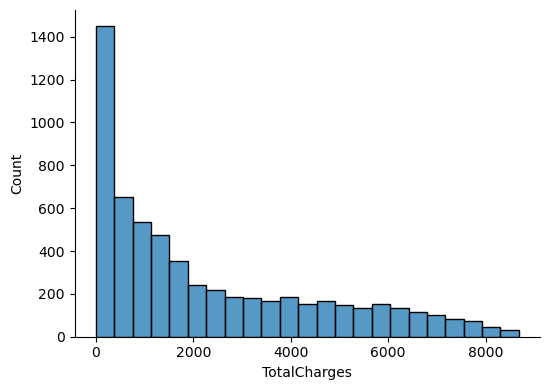

In [20]:
sns.displot(data=df, x='TotalCharges', height=4, aspect=1.4)
plt.show()

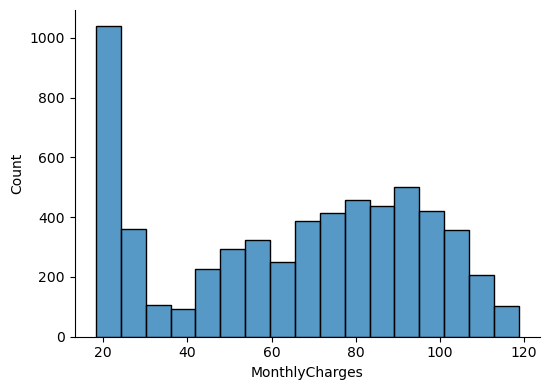

In [21]:
sns.displot(data=df, x='MonthlyCharges', height=4, aspect=1.4)
plt.show()

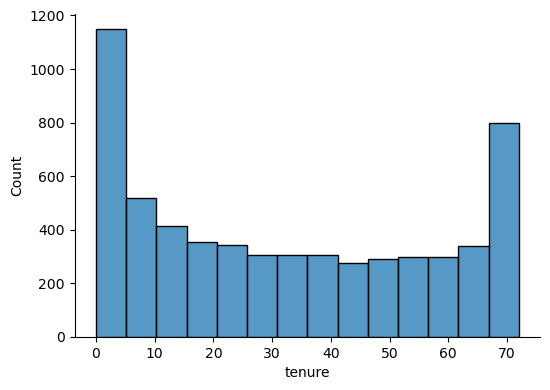

In [22]:
sns.displot(data=df, x='tenure', height=4, aspect=1.4)
plt.show()

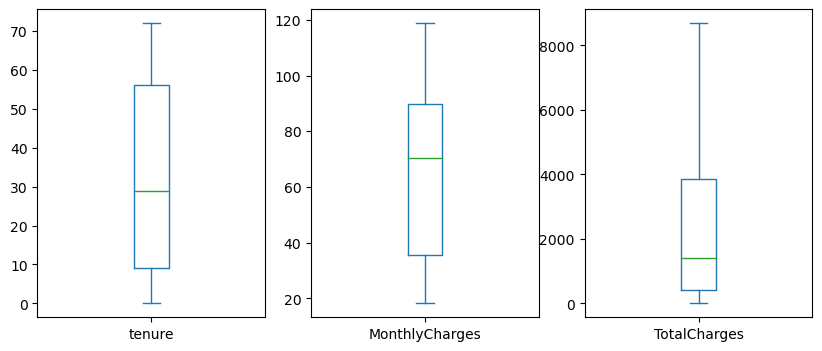

In [23]:
# Boxplot
df[numeric_vars].plot(kind='box',subplots=True, layout=(1,3), figsize=(10,4))
plt.show()

In [24]:
# Create a list with categorical variables with more than two unique values
levels_list = [x for x in df[cat_vars].columns if df[x].nunique() > 2]
print(levels_list)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


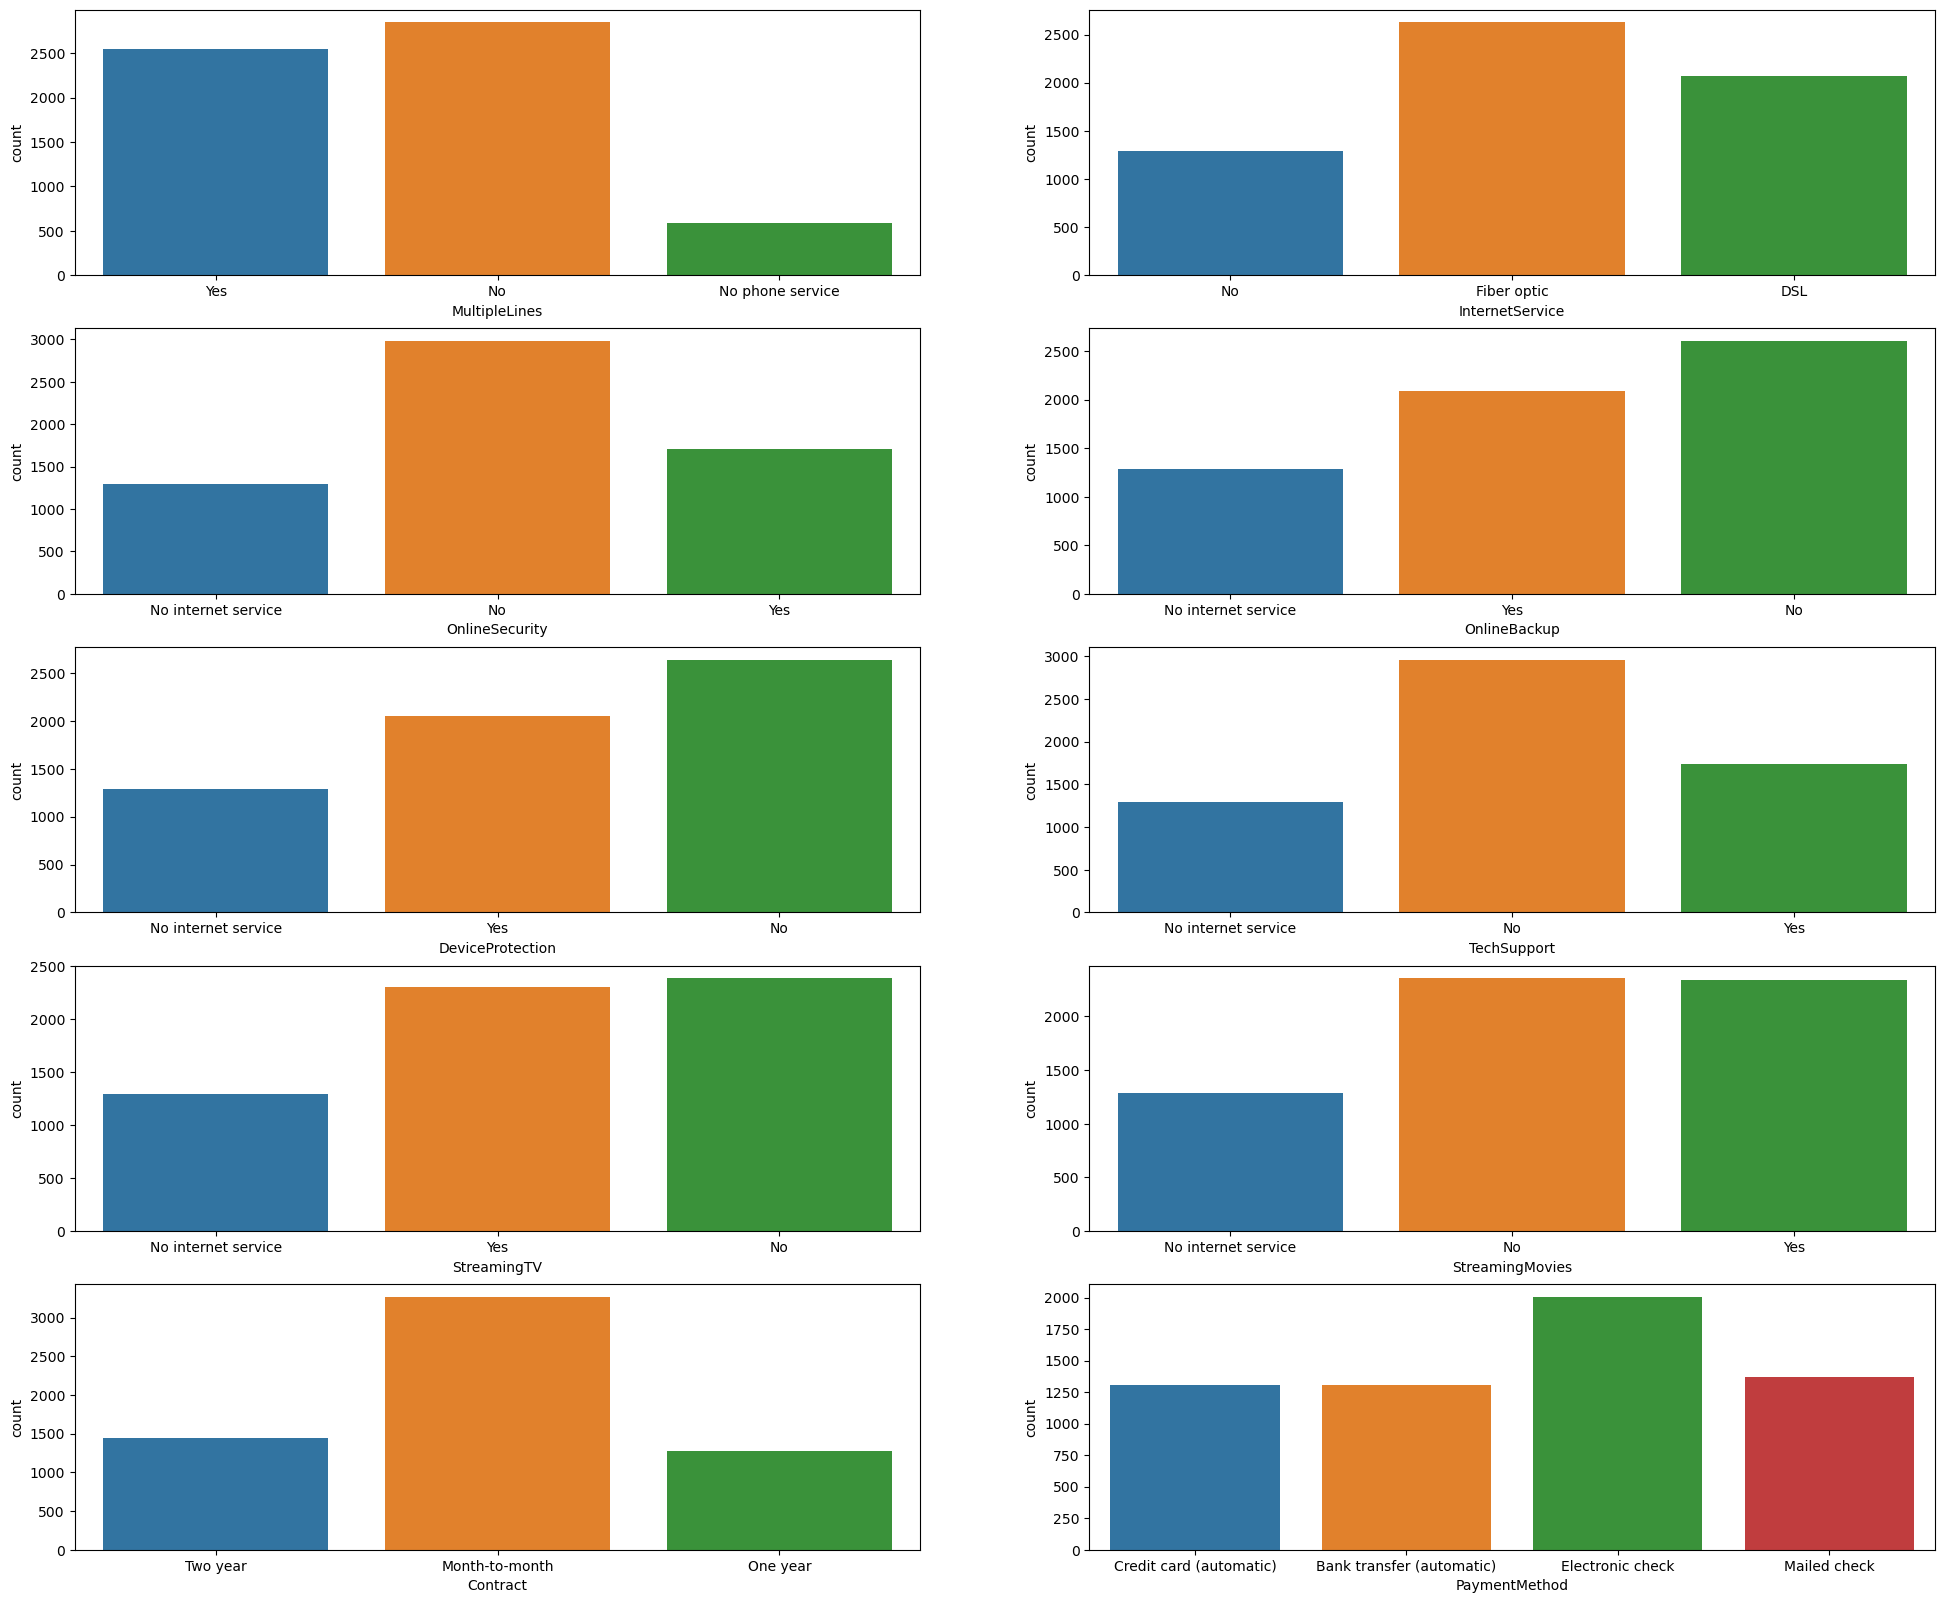

In [25]:
#  Categorical Data
a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(24,20))

for i in levels_list:
    plt.subplot(a, b, c)
    plt.xlabel(i)
    sns.countplot(df[i])
    c = c + 1

plt.show()

In [26]:
plt.clf()

In [27]:
# Create a list with categorical variables with two unique values
binary_list = [x for x in df[cat_vars].columns if df[x].nunique() == 2]
print(binary_list)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


<Figure size 640x480 with 0 Axes>

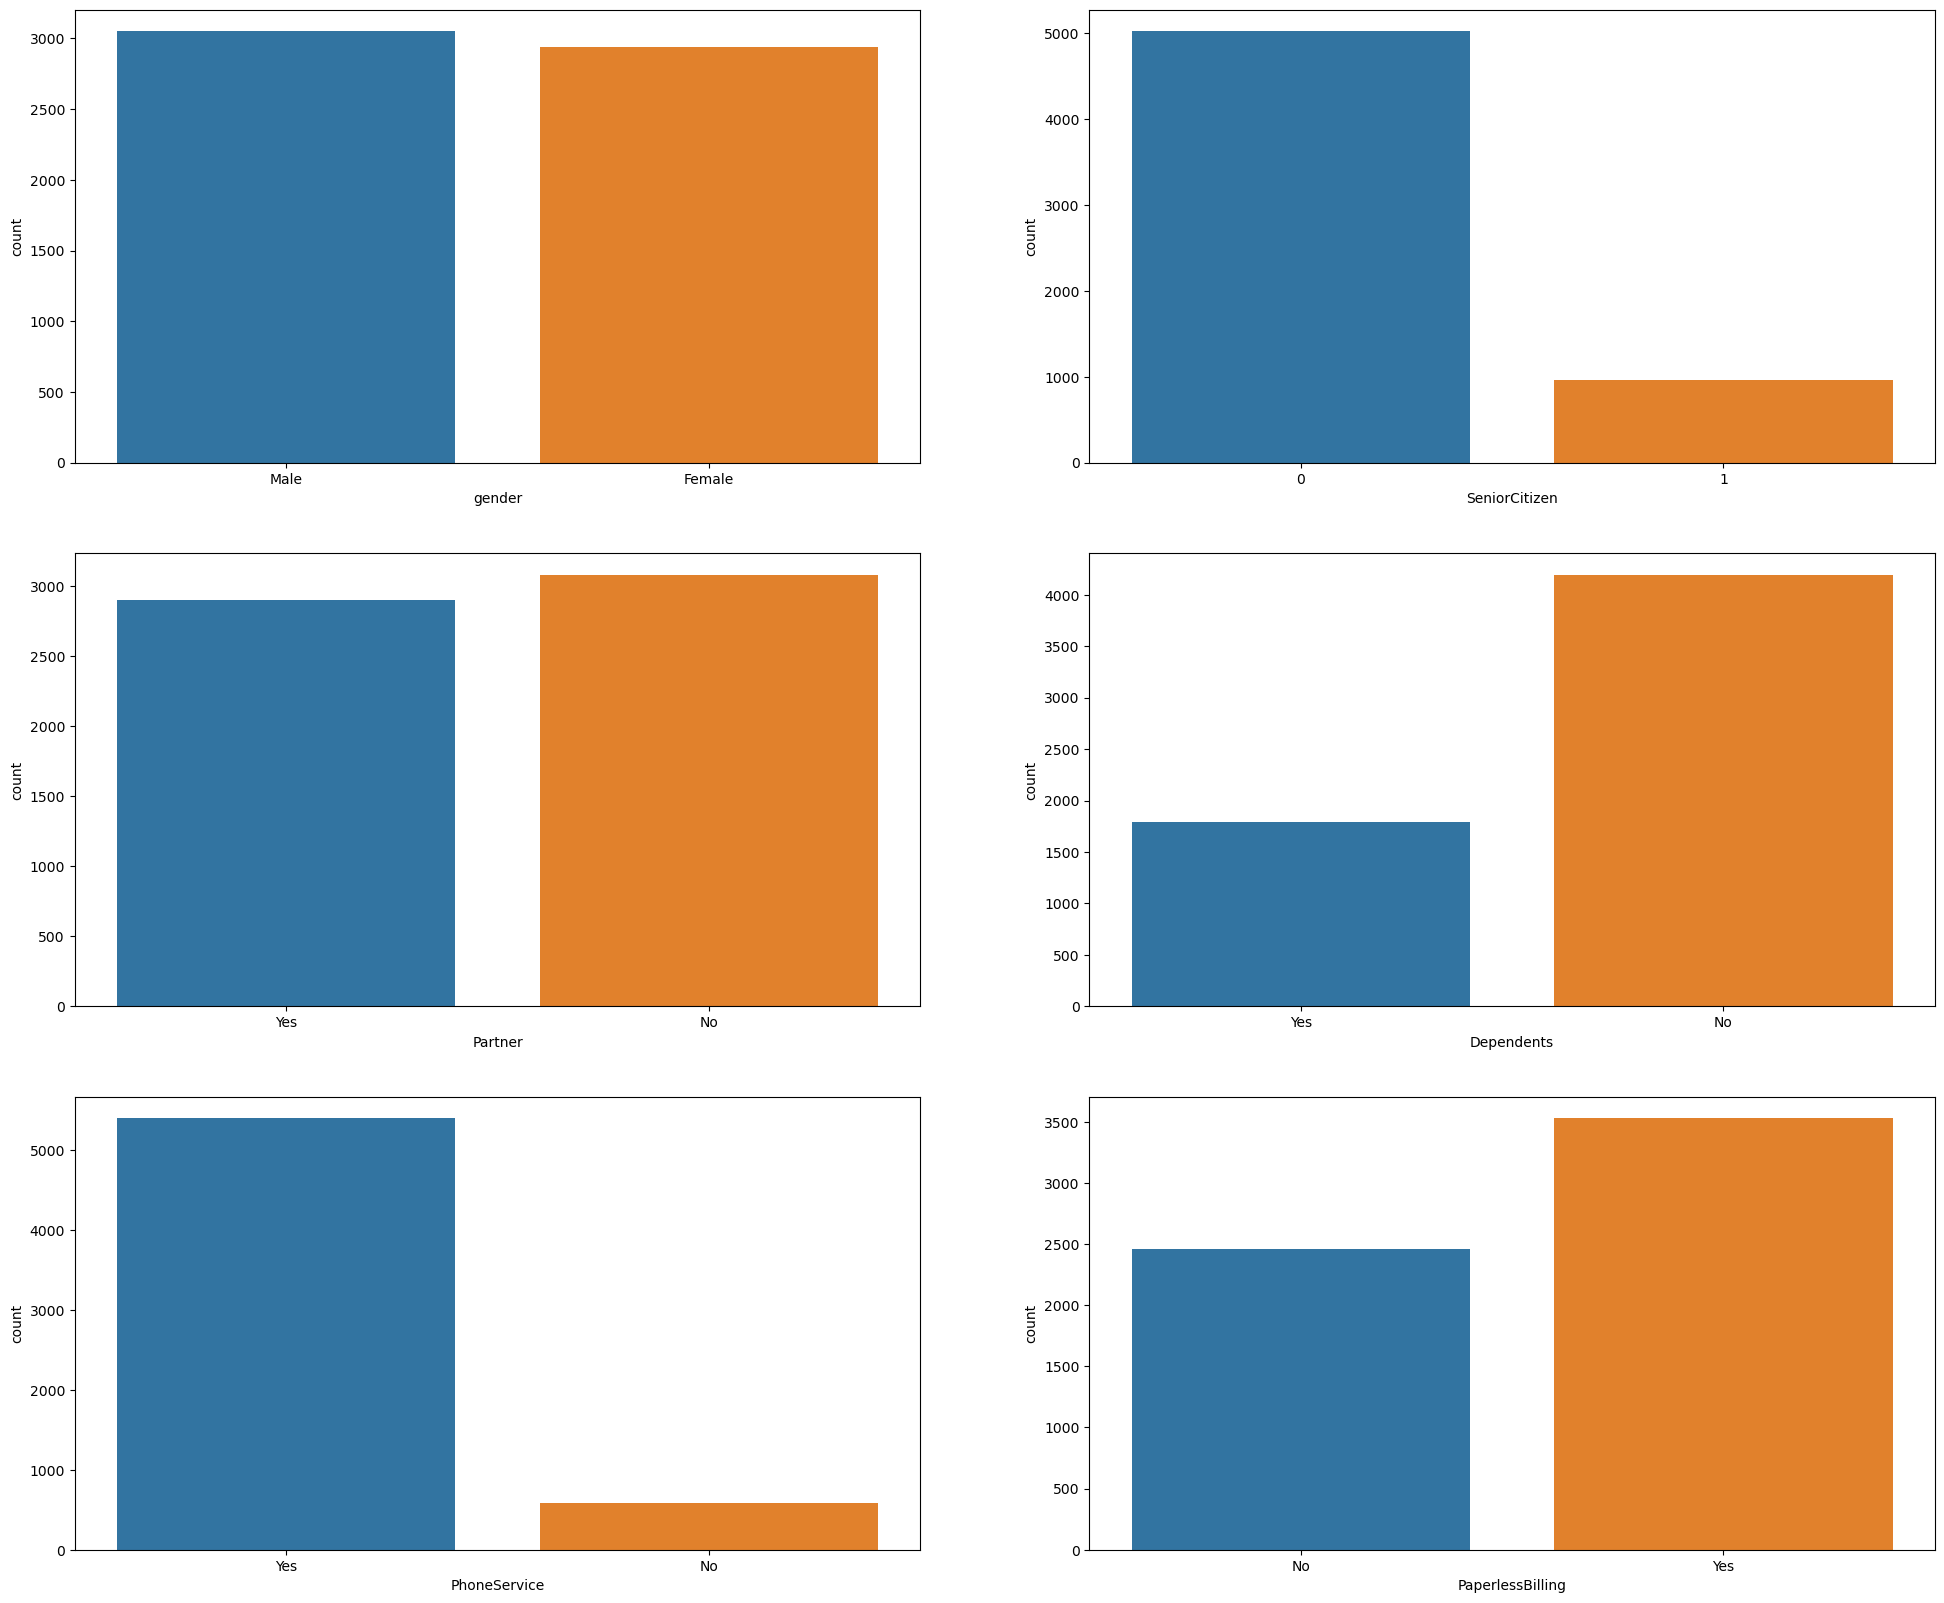

In [28]:
#  Binary Data
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(24,20))

for i in binary_list:
    plt.subplot(a, b, c)
    plt.xlabel(i)
    sns.countplot(df[i])
    c = c + 1

plt.show()

In [29]:
# Converting yes no to binary
y = y.replace(to_replace = ['Yes','No'], value = ['1','0'])
y = y.astype('int')

In [30]:
# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
# Encoding Caegorical variables
enc = OrdinalEncoder(dtype=np.int64)
X_train[cat_vars] = enc.fit_transform(X_train[cat_vars])
X_test[cat_vars] = enc.transform(X_test[cat_vars])

### MODEL DEFINITION 


In [32]:
# RANDOM FOREST
rf = RandomForestClassifier(random_state=42)

str_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_rf = {
            'n_estimators': [300, 400, 500, 800, 1000, 1200],
            'max_depth': [2, 4, 6, 8],
            'max_features': ['log2', 'sqrt'],
            'min_samples_split': [2, 5, 10],
            'max_leaf_nodes': [1, 2, 3, 4, 5],
            'max_samples': [0.6, 0.8, 1]
}

# Instantiate 'rs_rf'
rs_rf = RandomizedSearchCV(estimator=rf,
                            param_distributions=params_rf,
                            cv=str_kf,
                            scoring='roc_auc',
                            verbose=1,
                            n_jobs=-1)

In [33]:
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8],
                                        'max_features': ['log2', 'sqrt'],
                                        'max_leaf_nodes': [1, 2, 3, 4, 5],
                                        'max_samples': [0.6, 0.8, 1],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 400, 500, 800,
                                                         1000, 1200]},
                   scoring='roc_auc', verbose=1)

In [34]:
rs_rf.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'max_samples': 0.8,
 'max_leaf_nodes': 5,
 'max_features': 'sqrt',
 'max_depth': 8}

In [35]:
rs_rf.best_score_

0.8320246960077039

In [36]:
# use best params
rf_best = RandomForestClassifier(n_estimators = 800, max_features = 'sqrt', max_depth = 8, max_leaf_nodes = 5,
                                max_samples = 0.8, min_samples_split = 10, random_state=42)

In [37]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features='sqrt', max_leaf_nodes=5,
                       max_samples=0.8, min_samples_split=10, n_estimators=800,
                       random_state=42)

In [38]:
print("Training score:" + str(rf_best.score(X_train, y_train)))
print("Test score:" + str(rf_best.score(X_test, y_test)))
print("ROC AUC score:" + str(roc_auc_score(y_test, rf_best.predict(X_test))))

Training score:0.7972013366750209
Test score:0.7796327212020033
ROC AUC score:0.6361170668953688


In [39]:
### SVM with pipeline
scaler = StandardScaler()

In [40]:
svm = SVC(random_state=42)

In [41]:
pipe = Pipeline(steps=[('scaler', scaler), ('svm', svm)])

In [42]:
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svm__kernel': ['rbf']
}

In [43]:
gs_svc = GridSearchCV(pipe, param_grid, n_jobs=-1)

In [44]:
gs_svc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svm__kernel': ['rbf']})

In [45]:
gs_svc.best_score_

0.8001254354792616

In [46]:
gs_svc.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, gamma=0.01, random_state=42))])

In [47]:
# best_params
svm_best = SVC(C=10, gamma=0.01)

In [48]:
scaler = StandardScaler()

In [49]:
pipe = Pipeline(steps=[('scaler', scaler), ('svm', svm_best)])

In [50]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=10, gamma=0.01))])

In [51]:
print("Training score:" + str(pipe.score(X_train, y_train)))
print("Test score:" + str(pipe.score(X_test, y_test)))
print("ROC AUC score:" + str(roc_auc_score(y_test, pipe.predict(X_test))))

Training score:0.810359231411863
Test score:0.7896494156928213
ROC AUC score:0.6861134934248142


In [52]:
### XGB
xgb_param_dist = {
    'learning_rate': [0.2, 0.1, 0.05, 0.02, 0.01],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1, 5]}

In [53]:
xgb = XGBClassifier(objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=42)

str_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs_xgb = RandomizedSearchCV(estimator=xgb,
                            param_distributions=xgb_param_dist,
                            cv=str_kf,
                            scoring='roc_auc',
                            verbose=1,
                            n_jobs=-1)

In [54]:
rs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(nthread=4, seed=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.2, 0.1, 0.05, 0.02,
                                                          0.01],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   scoring='roc_auc', verbose=1)

In [55]:
rs_xgb.best_score_

0.8462117278888626

In [56]:
rs_xgb.best_params_

{'subsample': 0.8,
 'n_estimators': 150,
 'max_depth': 6,
 'learning_rate': 0.02,
 'gamma': 0,
 'colsample_bytree': 0.8}

In [57]:
# best params
xgb_best = XGBClassifier(objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=42,
                    scoring='roc_auc',
                    subsample=0.8, 
                    n_estimators=150, 
                    max_depth=6, 
                    learning_rate=0.02,
                    gamma=0,
                    colsample_bytree=0.8)

In [58]:
xgb_best.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, learning_rate=0.02, max_depth=6,
              n_estimators=150, nthread=4, scoring='roc_auc', seed=42,
              subsample=0.8)

In [59]:
print("Training score:" + str(xgb_best.score(X_train, y_train)))
print("Test score:" + str(xgb_best.score(X_test, y_test)))
print("ROC AUC score:" + str(roc_auc_score(y_test, xgb_best.predict(X_test))))

Training score:0.8475355054302423
Test score:0.7913188647746243
ROC AUC score:0.6932747284162378


In [60]:
### ADABOOST
ada = AdaBoostClassifier(random_state=42)

str_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

params_ada = {
            'n_estimators': [300, 400, 500],
            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
            }

# Instantiate 'rs_ada'
rs_ada = RandomizedSearchCV(estimator=ada,
                            param_distributions=params_ada,
                            cv=str_kf,
                            scoring='roc_auc',
                            verbose=1,
                            n_jobs=-1)

In [61]:
rs_ada.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1.0],
                                        'n_estimators': [300, 400, 500]},
                   scoring='roc_auc', verbose=1)

In [62]:
rs_ada.best_score_

0.8463882749468029

In [63]:
rs_ada.best_params_

{'n_estimators': 500, 'learning_rate': 0.1}

In [64]:
# Best estimator
ada_best = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.1)

ada_best.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=500)

In [65]:
print("Training score:" + str(ada_best.score(X_train, y_train)))
print("Test score:" + str(ada_best.score(X_test, y_test)))
print("ROC AUC score:" + str(roc_auc_score(y_test, ada_best.predict(X_test))))

Training score:0.8118212197159566
Test score:0.8013355592654424
ROC AUC score:0.7141509433962264


In [85]:
### LightGBM
lgbm = LGBMClassifier(random_state=42)

str_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

lgb_param_dist = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [3, 4, 5, 6],
    'num_leaves': [8, 16, 32, 64],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'min_data_in_leaf': [20, 50, 100, 200, 300]}

In [86]:
rs_lgbm = RandomizedSearchCV(estimator=lgbm,
                            param_distributions=lgb_param_dist,
                            cv=str_kf,
                            scoring='roc_auc',
                            verbose=1,
                            n_jobs=-1)

In [87]:
rs_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1.0],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_data_in_leaf': [20, 50, 100, 200,
                                                             300],
                                        'n_estimators': [10, 50, 100, 500,
                                                         1000],
                                        'num_leaves': [8, 16, 32, 64]},
                   scoring='roc_auc', verbose=1)

In [88]:
rs_lgbm.best_score_

0.8462846873955442

In [89]:
rs_lgbm.best_params_

{'num_leaves': 32,
 'n_estimators': 500,
 'min_data_in_leaf': 100,
 'max_depth': 3,
 'learning_rate': 0.01,
 'boosting_type': 'gbdt'}

In [90]:
lgb_best = LGBMClassifier(n_estimators = 500, learning_rate = 0.01, num_leaves=32, max_depth=3, 
                          boosting_type='gbdt', min_data_in_leaf=100)

In [91]:
lgb_best.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=3, min_data_in_leaf=100,
               n_estimators=500, num_leaves=32)

In [92]:
print("Training score:" + str(lgb_best.score(X_train, y_train)))
print("Test score:" + str(lgb_best.score(X_test, y_test)))
print("ROC AUC score:" + str(roc_auc_score(y_test, lgb_best.predict(X_test))))

Training score:0.8185045948203843
Test score:0.7938230383973289
ROC AUC score:0.6949792738707833


In [93]:
### STACKING MODELS
str_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [94]:
rf_best_params = {'n_estimators': 500, 'min_samples_split': 10, 'max_samples': 0.8, 'max_leaf_nodes': 4, 
                  'max_features': 'sqrt', 'max_depth': 4}

In [95]:
svc_best_params = {'C': 10, 'gamma':0.01}

In [96]:
xgb_best_params = {'subsample': 0.7, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 5, 
                   'colsample_bytree': 0.8}

In [97]:
ada_best_params = {'n_estimators': 300, 'learning_rate': 0.1}

In [98]:
xgb = XGBClassifier(**xgb_best_params, random_state=22)
rf = RandomForestClassifier(**rf_best_params, random_state=22)
svc = SVC(**svc_best_params, random_state=22)
ada = AdaBoostClassifier(**ada_best_params, random_state=22)

In [99]:
# Base estimators
estimators = [('xgb', xgb), ('rf', rf), ('svc', svc), ('ada', ada)]

In [100]:
# Final estimator LGBM
final_lgbm = LGBMClassifier(n_estimators = 500, learning_rate = 0.01, num_leaves=16, max_depth=5, boosting_type='goss', 
                            min_data_in_leaf=100)

In [101]:
clf_lgbm = StackingClassifier(estimators=estimators, final_estimator=final_lgbm, cv = str_kf)

In [102]:
clf_lgbm.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(colsample_bytree=0.8, gamma=5,
                                              learning_rate=0.02, max_depth=5,
                                              n_estimators=150, random_state=22,
                                              subsample=0.7)),
                               ('rf',
                                RandomForestClassifier(max_depth=4,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=4,
                                                       max_samples=0.8,
                                                       min_samples_split=10,
                                                       n_estimators=500,
                                                       random_state=22)),
                            

In [103]:
print("Training score:" + str(clf_lgbm.score(X_train, y_train)))
print("Test score:" + str(clf_lgbm.score(X_test, y_test)))
print("ROC AUC score:" + str(roc_auc_score(y_test, clf_lgbm.predict(X_test))))

Training score:0.825187969924812
Test score:0.7971619365609349
ROC AUC score:0.7002644368210407
